<a href="https://colab.research.google.com/github/hsscholte/psyForum/blob/master/PsychForum_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Psyforum Tutorial 1: Training a deep neural network (v1.4)
Lynn Sörensen & H.Steven Scholte

### Welcome! 
In this tutorial you will learn how to train a convolutional deep neural network (DCNN) on a simple object recognition task.

You will 
* build a Resnet model and look at its architecture <br/>
* train it on CIFAR10 <br/>
* ...with different learning schedules and observe the effects <br/>

next, you will
* design your own model and training scheme to get an optimal classification on a task. 

This tutorial is also going to get you acquainted with a dataset and a model architecture that will be used in a later tutorial. 

#### Some extra information:
There are different types of exercises throughout this tutorial, including:

- <font color='darkorange'><b>ToDos</b></font> : short programming exercises 
- <font color='cornflowerblue'><b>ToThinks</b></font>: questions about the (preceding) text/material

Sometimes, you also encounter <font color='limegreen'><b>Tips and Tricks</b></font>, which may contain advice, more information on a specific topic, or links to relevant websites or material.

#### GPU support
Don't forget to change your runtime type to GPU accelerator if you want to train these model. Click on `Runtime` above this notebook in the Colab environment and then on `Change Runtime Type`. Set Hardware accelerator to `GPU`.




### Let's start!

With importing the necessary packages:

In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.models import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


And connect our google drive!

In [0]:
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


And lets create a directory in your gdrive to store the models

In [0]:
mkdir "/gdrive/My Drive/PsyForum"

mkdir: cannot create directory ‘/gdrive/My Drive/PsyForum’: File exists


And define some useful functions for later!

In [0]:
def save_pickle(obj, name):
    try:
        filename = open(name + ".pickle","wb")
        pickle.dump(obj, filename)
        filename.close()
        return(True)
    except:
        return(False)


def load_pickle(filename):
    return pickle.load(open(filename, "rb"))
  
def plot_training(history, title=None):
  epochs = len(history.history['loss'])
  if 'lr' in history.history:
    fig, ax = plt.subplots(1, 3, figsize=(20,5))
    ax = ax.flatten()
    ax[0].plot(np.arange(epochs), np.transpose([history.history['loss'], history.history['val_loss']]))
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,3])
    ax[0].legend(['training', 'validation'])

    ax[1].plot(np.arange(epochs), np.transpose([history.history['acc'], history.history['val_acc']]))
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].set_ylim([0,1])
    ax[1].legend(['training', 'validation'])
    
    ax[2].plot(np.arange(epochs), history.history['lr'])
    ax[2].set_xlabel('epochs')
    ax[2].set_ylabel('learning rate')
    #ax[2].set_ylim([0,1])
  else:
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax = ax.flatten()
    ax[0].plot(np.arange(epochs), np.transpose([history.history['loss'], history.history['val_loss']]))
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,3])

    ax[1].plot(np.arange(epochs), np.transpose([history.history['acc'], history.history['val_acc']]))
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].set_ylim([0,1])
    fig.legend(['training', 'validation'])
  if title:
    fig.suptitle(title)
  fig.show()


**bold text**## Part 1: Train a network on a simple object recognition task with different training schemes
In this part of the tutorial, you will be training a DCNN to solve object categorization on [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). We will use this dataset because it is relatively quick to train and still allows you to observe interesting behavior. The specific version of ResNet is based on [ResNetCifar10](http://www.pabloruizruiz10.com/resources/CNNs/ResNet-on-CIFAR10.pdf).

The logic of this part of the tutorial will be that you observe that effects of different choices (e.g. learning rate, data augmentation) that you make when you decide to train a DCNN from scratch. Training a DCNN can be tricky and the interaction between different decisions difficult to anticipate. 

Our goal for the first part is to replicate the training from the Resnet paper, one of the most successful architectures that is still widely used to day, despite its relatively old age for the deep learning community. To do this, we will be adding component by component to our training and obeserve in how it helps. 

So let's get started!

For all of the following experiments, we need:
* A stimulus set - CIFAR10
* A ResNet architecture




### 1.1 Stimulus set: CIFAR10
The CIFAR10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

This dataset is a standard benchmark in the Computer vision community to benchmark new architecture and training regimes.

<font color='darkorange'><b>ToDo:</b></font> Fill in the missing parts in the code below by replacing the 'FILL'.
Check out the objects. Plot a couple of examples for every category.

170500096/170498071 [==============================] - 11s 0us/step


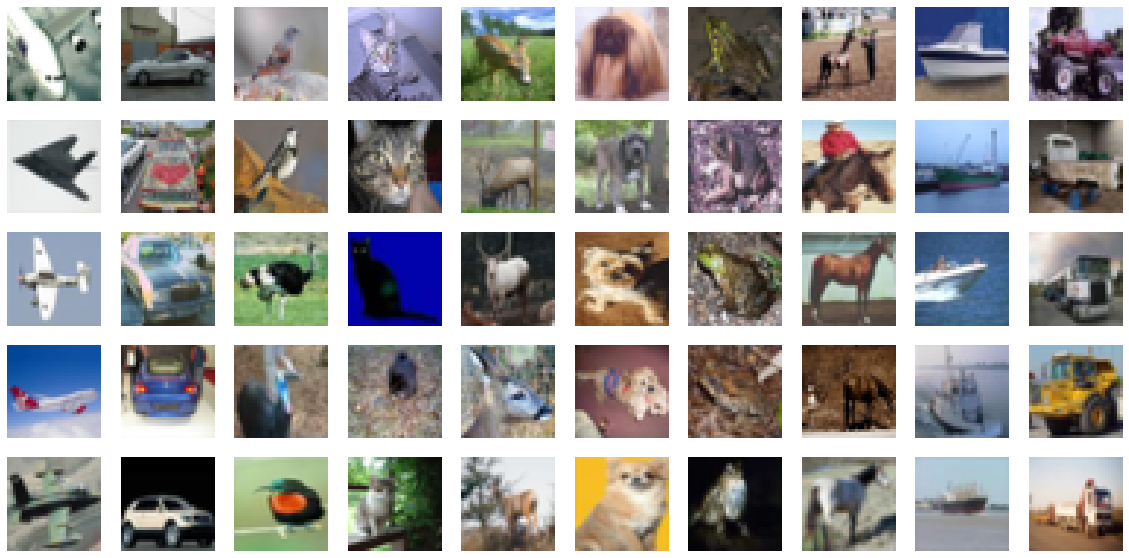

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# How many classes are there?
num_classes = 10

# Plots some examples here.
num_examples = 5
fig, ax = plt.subplots(num_examples, num_classes, figsize=(20,10))
for c in range(num_classes):
  class_idx = np.where(y_train == c)[0] # for a given class
  for e in range(num_examples): #pick some random examples from the training set
    # ax[e,c].imshow(FILL) 
    ax[e,c].imshow(x_train[class_idx[np.random.randint(len(class_idx))],:,:,:]) 
    ax[e,c].axis('off')




### 1.2 Data preparation
Humans and networks need different inputs and labels. Comparable to the range of light intensities that we are able to perceive, we need to transfer the images into a space where the networks can easily compute on them. This means, we will have to convert our images to have values between 0 and 1. 

<font color='cornflowerblue'><b>ToThink:</b></font> Why do you think the network can deal better with inputs between 0-1?




ANSWER: Inputs in a bounded range allow the network to learn and find weights that are not too extreme. Since we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

We'd like in this process for each feature to have a similar range so that our gradients don't go out of control.


<font color='darkorange'><b>ToDo:</b></font> Fill in the missing parts in the code below by replacing the 'FILL'.

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


While we have an easy time understanding the label 'bird', we need to express categories as numbers for the network. The next step will be to also express the labels of the target category as a 1-hot-vector. This just means that you have a vector with zeros corresponding to all labels and you put a 1 for the right target category. Fortunately, Keras has a nice set of 'utils' to help us with that. For example keras.utils.to_categorical converts a class vector of integers to a binary class matrix.


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 1.3 Validation set

As a last step, we'll set aside some of our training data as a validation dataset. This allows us to estimate how well our current model performs without touching the test set. 

<font color='cornflowerblue'><b>ToThink:</b></font> Do you recall why it is useful to have a validation set?



ANSWER: A validation set gives you an estimate of how well your current solution of weights will generalize to the test set.

In [0]:
# We take here 10% of our training set as a validation set. 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3) # 30k train, 10k val

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)

print('x_val shape:', x_val.shape)
print(x_val.shape[0], 'val samples')
print('y_val shape:', y_val.shape)





x_train shape: (37500, 32, 32, 3)
37500 train samples
y_train shape: (37500, 10)
x_val shape: (12500, 32, 32, 3)
12500 val samples
y_val shape: (12500, 10)



<font color='limegreen'><b>Tips and Tricks</b></font>: Here we use a function from sklearn, this is one way to do it. Keras also allows you to make a validation set on the fly with an argument validationSplit in the [ImageDataGenerator class](https://keras.io/preprocessing/image/).

Notice that we also still have a test set that we obtained when we loaded cifar10. Below we inspect its dimensions:

In [0]:
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)

x_test shape: (10000, 32, 32, 3)
10000 test samples
y_test shape: (10000, 10)


<font color='cornflowerblue'><b>ToThink:</b></font> Why do you think we have 3 datasets, train, validate and test?

### 1.4 Resnet architecture

Now let's move on to the Resnet architecture. Since the images of CIFAR10 are only 32x32x3, the network to classify them cannot be too deep (remember the effect of convolution and pooling operations). For that reason, the authors of Resnet made a mini-version tailored to CIFAR10. The most important differences to the Resnet-version used on Imagenet (224x224x3 images) is the amount of blocks and the depth of the filters. Also, to somewhat reduce the performance we have made the network slightly smaller. 

<font color='darkorange'><b>ToDo:</b></font> Go over the definitions below and make sure to understand how it works.

In [0]:
# Below you can see the definition of a resnet block. 

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    # This is how you defince a 2D convolutional layer. 
    # At this point this is just a pre-defined function and not a layer yet!
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer= keras.regularizers.l2(1e-4))
    # This is where we start to chain the layers together.
    x = inputs # any block will start with the inputs given to this function.
    if conv_first: # This if-else statement refers to that there are two-ways of constructing the Resnet-block.
        x = conv(x) # Append the conv function from above to the input. 
        if batch_normalization:
            x = BatchNormalization()(x) # Here we add the Batchnormalization in the same way. 
        if activation is not None:
            x = Activation(activation)(x) # And similarly for the Activation function.
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
  
  # These operations will be repeated many times and as result 


In [0]:
# and this is how the model is put together.
  
def resnet_v1(input_shape, depth=8, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Adapted from https://keras.io/examples/cifar10_resnet/
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet10 0.14M
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor (dim1,dim2,channels)
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # if (depth - 2) % 6 != 0:
    #    raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) 
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            # This defines the first branch in which all the weight layer are. 
            y = resnet_layer(inputs=x, 
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y, 
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y]) # Here the first branch is added to the residual.
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
  

<font color='darkorange'><b>ToDo:</b></font> Build the model with the functions above (by using the default settings!)


In [0]:
# Build the model
model = resnet_v1(input_shape=input_shape)

# ... and show the architecture
model.summary()













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
________________________________________________________________________________

Voilà, your model!
So what is going on inside of a Resnet-Model?

![alt text](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png) 

Above the same operations are shown as a graphic. x refers to the current end of the model, that can be any layer. A weight later would a Conv2D layer. relu refers to the activation function. In our case, this is also integrated in the Conv2D layer (see the activation argument in the resnet layer function). 

<font color='cornflowerblue'><b>ToThink:</b></font>  Can you see how this schematic fits with the model.summary output? 
How many of these blocks are there in total? Follow the Add operation!



ANSWER: There are 3 blocks in total.

There are range of different resnet types with varying depths! The depths in the name is determined by the amount of Convolutional and Dense layers.

<font color='cornflowerblue'><b>ToThink:</b></font> In the current case, how many convolutional and dense layers are there respectively?



ANSWER: There are 9 convolutional and 1 dense layer, making it a 10 layer network.

<font color='limegreen'><b>Tips and Tricks</b></font>: There is a range of models available provided by Keras with pretrained weights on ImageNet that are easy to use such as VGG or Inception. For more info see [here](https://keras.io/applications/#available-models).

### 1.5 Training options

Our model currently has random weights, that means, it has not been trained to do any task. Let's see what that means. For example if we have it classify the CIFAR10 training set.

#### 1.5.0 model.compile
Before a freshly assembled model can be trained or tested, it first needs to be compiled. That means we add our loss function (e.g. categorical_crossentropy), a training optimizer (remember stochastic gradient descent!) and a metric to compare between the model answer and the true answer (accuracy).


<font color='darkorange'><b>ToDo:</b></font> Check out https://keras.io/optimizers/ for an overview of all available optimizers and their defaults. Set up the compile function with categorical crossentropy, stochastic gradient descent and accuracy as a metric!


In [0]:
sgd = keras.optimizers.SGD() # select optimizer
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc'])  # select way of calculating loss and expressing accuracy
scores = model.evaluate(x_train, y_train, verbose=1) # evaluate model

print('Training loss:', scores[0])
print('Training accuracy:', scores[1])



37500/37500 [==============================] - 10s 266us/step
Training loss: 3.696129176152547
Training accuracy: 0.0994933333381017


<font color='cornflowerblue'><b>ToThink:</b></font> What does the training loss mean? Is the training accuracy like you would expect and if so, why? 



#### 1.5.1 Training with standard gradient descent and a large batch size
Now let's start with teaching the model the task of distinguishing the 10 different object categories in CIFAR10. 

In the lecture, we have seen that a big part of successful training is choosing the right batch size, gradient update & learning rate at the right moment in time. Below, we are going to train our model in different ways and change this part in our training. 

As a result of how we set up our model above (model.compile ...), we accepted the default parameters of the SGD optimizer. The gradient updates will follow the steepest gradient throughout our entire training. 

<font color='cornflowerblue'><b>ToThink:</b></font> Do you think this is a good strategy?



ANSWER: In general, there is nothing wrong about accepting the default values. Yet the basic concept of gradient descent is great but there might be some smarter ways to selet these values. Figuring out which these are, in such a way that the model is not overfitted is a central skill.

<font color='darkorange'><b>ToDo:</b></font> Can you set up the training below with the model.fit() function? Remember, we set aside a validation dataset, to evaluate how well our model will generalize to the test set! Choose a batch-size of 5000 and run it for 30 epochs!

<font color='limegreen'><b>Tips and Tricks</b></font>: In the snippet of code there is already a modelcheckpoint set up for you. This will safe the currently best-performing model automatically. 

In [0]:
epochs = 30
batch_size = 5000

# Training of the model
history_151 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/PsyForum/weights_151.h5')
save_pickle(history_151, '/gdrive/My Drive/PsyForum/history_151')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 37500 samples, validate on 12500 samples
Epoch 1/30
37500/37500 [==============================] - 5s 146us/step - loss: 2.9064 - acc: 0.1150 - val_loss: 2.6214 - val_acc: 0.1213
Epoch 2/30
37500/37500 [==============================] - 3s 73us/step - loss: 2.4975 - acc: 0.1415 - val_loss: 2.4141 - val_acc: 0.1529
Epoch 3/30
37500/37500 [==============================] - 3s 73us/step - loss: 2.3348 - acc: 0.1760 - val_loss: 2.3123 - val_acc: 0.1674
Epoch 4/30
37500/37500 [==============================] - 3s 73us/step - loss: 2.2570 - acc: 0.1978 - val_loss: 2.2566 - val_acc: 0.1861
Epoch 5/30
37500/37500 [==============================] - 3s 73us/step - loss: 2.2155 - acc: 0.2157 - val_loss: 2.2202 - val_acc: 0.2032
Epoch 6/30
37500/37500 [==============================] - 3s 73us/step - loss: 2.1900 - acc: 0.2284 - val_loss: 2.1962 - val_acc: 0.2179
Epoch 7/30
37500/37500 [=======

OSError: ignored

The history object contains an overview of the training. With that you can inspect how the training went. 

In [0]:
plot_training(history_151, title='1.5.1 Training with a static learning rate, large batch size')

So what do we see here? Neither the performance on the training or validation set increased in an impressive maner. 

<font color='cornflowerblue'><b>ToThink:</b></font> This is an effect of the large batch size. Why?







#### 1.5.2 Training with standard gradient descent and a small batch size


<font color='darkorange'><b>ToDo:</b></font> We will now reduce our batchsize to 36 and evaluate the performance again. Keep, for once, 50 epochs (and get some coffee).

In [0]:
# epochs = FILL
# batch_size = FILL
epochs = 50
batch_size = 36

# Training of the model
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc']) 

# history_152 = model.fit(FILL, shuffle=True)  
history_152 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_152.h5')
save_pickle(history_152, '/gdrive/My Drive/CCN2019/history_152')


The history object contains an overview of the training. With that you can inspect how the training went. 

In [0]:
plot_training(history_152, title='1.5.2 Training with a static learning rate, small batch size')

So what do we see here? While the model continued to fit the training set (contrary to 1.5.1). The corresponding measures on the validation improved substantially less, and also sometimes deteriorated. 

<font color='cornflowerblue'><b>ToThink:</b></font> Which scenario from the lecture could this correspond to? For later epochs, is the learning rate too small, too big, way too big or equal to the optimal learning rate?








ANSWER: For later epochs, this corresponds to choosing a too big learning rate since the training actually doesn't improve the performance over time. The big jumps in the loss also indicate that it is making too big steps after a single epoch.

#### 1.5.3 Training with momentum

This went *ok*. But we can do better! Do you remember the difficult landscape from the lecture? There might be smarter ways how we can travel through this landscape! 

<font color='cornflowerblue'><b>ToThink:</b></font> Can you describe in your own words, how we traveled the landscape in the last training? What does the learning rate mean in this analogy?






ANSWER: In the last training, we have always taken the same step size and followed the steepest slope. The learning rate corresponds to the size of the update, so a distance in the landscape. 

A start could be that we develop a better decision rule for which direction to follow. This means that it might not always be the best idea to follow the currently steepest gradient. 

This is exactly what training stochastic gradient descent with momentum does! The intuition behind is that when there was a certain direction that continuously had a gradient to learn from, this direction gains more weight. This can be imagined like a ball rolling downhill.

<font color='darkorange'><b>ToDo:</b></font> Can you set up a new model, compile it with a Nesterov-momentum of 0.9? You can keep all the other parameters the same. Train the model and see how it compares to the other training?

In [0]:
epochs = 50
batch_size = 36
 
# model_153 = FILL
# sgd_custom = keras.optimizers.SGD(FILL) 
# model_153.compile(FILL)
  
model_153 = resnet_v1(input_shape=input_shape)
sgd_custom = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) 
model_153.compile(loss='categorical_crossentropy',optimizer=sgd_custom,metrics=['accuracy'])

# history_153 = model.fit(FILL, shuffle=True)  
history_153 = model_153.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_153.h5')
save_pickle(history_153, '/gdrive/My Drive/CCN2019/history_153')

In [0]:
plot_training(history_153, title='1.5.3 Training with Nesterov-momentum')


This went a bit better. Do you remember the adaptive optimizers from the lecture (such as Adam, Adagrad and RMSprop)? These can be a great option as well when you don't know the right hyperparameters yet.

Please check out [this website](https://cs231n.github.io/neural-networks-3/#loss) for a insightful description as well as the list of keras optimizers mentioned above.

So taken together, we've seen that adding momentum helps your model to train and optimize.  



#### 1.5.4 Training with learning rate decay

Above we saw that we can deal with the bumpy loss landscapes in more optimal ways by using an optimizer to compute the best gradients to follow. However, these gradients are ultimately still bound to the specified learning rate (e.g. 0.01) for performing the update on the weights. Now we are going to explore some ways in which we can adapt the learning rate over time.

A sensible way to start could be to reduce the learning rate at every iteration a little bit. This is refferd to as learning rate decay. 

<font color='darkorange'><b>ToDo:</b></font> Can you set up a new model with learning rate decay with an initial learning rate of 0.01 and a decay of 1e-6? Again, you can keep all the other parameters the same. Train the model and see how it compares to the other training?




In [0]:
# to realise: lr *= (1. / (1. + self.decay * self.iterations))
epochs = 50
batch_size = 36

# model_154 = FILL
# sgd_custom = keras.optimizers.SGD(FILL) 
# model_154.compile(FILL)
# history_154 = model_153.fit(FILL, shuffle=True)

model_154 = resnet_v1(input_shape=input_shape)
sgd_decay = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
model_154.compile(loss='categorical_crossentropy',optimizer=sgd_decay,metrics=['accuracy'])
history_154 = model_154.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_154.h5')
save_pickle(history_154, '/gdrive/My Drive/CCN2019/history_154')

In [0]:
history_154.history['lr'] =  0.01 *  (1. / (1. + 1e-6 * np.arange(1,epochs+1))) 
plot_training(history_154, title='1.5.4 Training with learning rate decay')



<font color='cornflowerblue'><b>ToThink:</b></font> How does the reduction in learning rate compare to the other scenarios with a fixed learning rate? 

ANSWER: Based on the training history, we see that they were less strong fluctuations at later epochs of the training. 

#### 1.5.5 Training with a fixed learning rate schedule

As we discussed in the lecture, learning rate is one of the crucial hyperparameters, which is subject to optimization. If you in turn would like to replicate another paper, they sometimes mention a learning rate schedule that is optimized for this specific architecture and dataset. 

<font color='darkorange'><b>ToDo:</b></font> Can you come up with your own learning rate schedule below? Again, you can keep all the other parameters the same. Once, you are done, look at the provided training outcomes!

In [0]:
epochs = 50
batch_size = 36

# model_155 = FILL
model_155 = resnet_v1(input_shape=input_shape)

# We stick to a common optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) 
  
# def step_decay(epoch): 
#if epoch  < FILL:
#lrate=0.1
#elif epoch < FILL:
#lrate = 0.01
#else:
# lrate = 0.001
#  return lrate

def step_decay(epoch): 
  if epoch  < 10:
    lrate=0.1
  elif epoch < 30:
    lrate = 0.01
  else:
    lrate = 0.001
  return lrate

# and we hand the function to the training with acallback.
lr_reducer = keras.callbacks.LearningRateScheduler(step_decay)

model_155.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
history_155 = model_155.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),shuffle=True, callbacks = [lr_reducer])

model_155.save_weights('/gdrive/My Drive/CCN2019/weights_155.h5')
save_pickle(history_155, '/gdrive/My Drive/CCN2019/history_155')    

In [0]:
plot_training(history_155, title='1.5.5 Training with a fixed learning rate schedule')


<font color='cornflowerblue'><b>ToThink:</b></font> Can you tell from the plot at which epochs the learning rate was changed?

ANSWER: Based on the dips and the third plot, you can see that it was changed in the 10th and 30th epoch.

<font color='darkorange'><b>ToDo:</b></font> Plot all our training histories in one plot!





In [0]:
# load_pickle('/gdrive/My Drive/CCN2019/history_151.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_152.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_153.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_154.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_155.pickle')

plot_training(history_151, title='1.5.1 Training with large batch size and a fixed learning rate schedule')
plot_training(history_152, title='1.5.2 Training with small batch size and a fixed learning rate schedule')
plot_training(history_153, title='1.5.3 Training momentum')
plot_training(history_154, title='1.5.4 Training learning rate decay')
plot_training(history_155, title='1.5.5 Training fixed learning rate schedule')



<font color='cornflowerblue'><b>ToThink:</b></font> Which one worked the best?

ANSWER: Based on the comparison, the fixed training schedule seemed to have worked best. This is likely due to the fact that this schedule had a late phase with a very small learing rate, which allowed for very fine adjustments and that this was lacking in the other trainings. Also, this fixed schedule was based on the data-set making it a hyper parameter that has been optimized. 